In [19]:
import os
import datetime
import pandas as pd
import seaborn as sns

from utils.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Gather data

In [2]:
if not os.path.exists('data'):
    os.makedirs('data')

filepath = os.path.join('data', 'data.parquet')
if not os.path.isfile(filepath):
    tmp_data = gather_data(start='2023-01-01 00:00:00', stop='2023-12-31 23:00:00')
    tmp_data.to_parquet('data/data.parquet', compression='snappy')
    

## Load data

In [3]:
data = pd.read_parquet('data/data.parquet')

In [4]:
data.head()

,open_time,close_time,open,high,low,close,volume,n_trades
0,2023-01-01 00:00:00,2023-01-01 00:59:59.999,16541.77,16545.70,16508.39,16529.67,4364.83570,149854
1,2023-01-01 01:00:00,2023-01-01 01:59:59.999,16529.59,16556.80,16525.78,16551.47,3590.06669,126556
2,2023-01-01 02:00:00,2023-01-01 02:59:59.999,16551.47,16559.77,16538.14,16548.19,3318.84038,115398
3,2023-01-01 03:00:00,2023-01-01 03:59:59.999,16548.19,16548.19,16518.21,16533.04,4242.08050,137724
4,2023-01-01 04:00:00,2023-01-01 04:59:59.999,16533.04,16535.97,16511.92,16521.85,4285.00909,129535


## Prepare data

In [5]:
filtered_frame = data[['high', 'low', 'close', 'volume']]

# zero replacement
filtered_frame = zero_replacement(filtered_frame)

# rates of return
ror = rates_of_return(filtered_frame)

# lag the data
lagged_frame = lag_dataframe(ror, 'close')

In [12]:
# split to training and testing data
train, test = split_to_subsets(lagged_frame, seed=420)

# scale the data
scaled_train, scaled_test = normalize(train, test, exclude=['target'])

# prepare X_train, y_train, X_test, y_test
X_train, X_test = scaled_train.copy(), scaled_test.copy()
y_train, y_test = X_train.pop('target'), X_test.pop('target')

## Modelling

### Logistic Regression

In [20]:
lr = LogisticRegression(multi_class='multinomial', random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
conf_matrix = confusion_matrix(y_test.to_numpy(), y_pred)

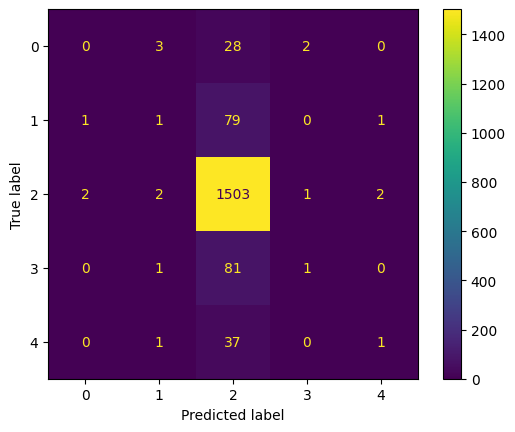

In [25]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = np.unique(y_train))
cm_display.plot()

2

### LSTM

In [8]:
# prepare X_train, y_train, X_test, y_test for LSTM
X_train, y_train = prepare_x_y(scaled_train)
X_test, y_test = prepare_x_y(scaled_test)